# @property explained

## Using Getters and Setters

Suppose we want to extend the usability of the Celsius class defined above. We know that the temperature of any object cannot reach below -273.15 degrees Celsius (Absolute Zero in Thermodynamics)

Let's update our code to implement this value constraint.

An obvious solution to the above restriction will be to hide the attribute temperature (`make it private`) and define new getter and setter methods to manipulate it. This can be done as follows:

In [23]:
# Making Getters and Setter methods
class Celsius:
    def __init__(self, temperature=0):
        self.set_temperature(temperature)

    def to_fahrenheit(self):
        return (self.get_temperature() * 1.8) + 32

    # getter method
    def get_temperature(self):
        return self._temperature

    # setter method
    def set_temperature(self, value):
        if value < -273.15:
            raise ValueError("Temperature below "
                             "-273.15 is not possible.")
        self._temperature = value

As we can see, the above method introduces two new `get_temperature()` and `set_temperature()` methods.

Furthermore, `temperature` was replaced with `_temperature`. An underscore _ at the beginning is used to denote private variables in Python.

In [24]:
# Create a new object, set_temperature() internally called by __init__
human = Celsius(37)

# Get the temperature attribute via a getter
print(human.get_temperature())

# Get the to_fahrenheit method, get_temperature() called by the method itself
print(human.to_fahrenheit())

# new constraint implementation
human.set_temperature(-300)

# Get the to_fahreheit method
print(human.to_fahrenheit())

37
98.60000000000001


ValueError: Temperature below -273.15 is not possible.

In [60]:
# using property class
class Celsius:
    def __init__(self, temp=0):
        self.temperature = temp

    def to_fahrenheit(self):
        return (self.temperature * 1.8) + 32

    # getter
    def get_temperature(self):
        print("Getting value...")
        return self._temperature

    # setter
    def set_temperature(self, value):
        print("Setting value...")
        if value < -273.15:
            self._temperature = -273.5
#             raise ValueError("Temperature below -273.15 is not possible")
        else:
            self._temperature = value
            

#     # creating a property object
#     temperature = property(get_temperature, set_temperature)

    # another way to define th property object
    temperature = property()
    temperature = temperature.getter(get_temperature)
    temperature = temperature.setter(set_temperature)


In [62]:
human = Celsius(37)

print(human.temperature)

print(human.to_fahrenheit())

human.temperature = -300
human.temperature

Setting value...
Getting value...
37
Getting value...
98.60000000000001
Setting value...
Getting value...


-273.5

In [79]:
class celsius:
    def __init__(self, temp = 0):
        self.temperature = temp
        
    def to_fahrenheit(self):
        return self.temperature * 1.8 + 32
    
    @property
    def temperature(self):
        print('Getting the value ...')
        return self._temperature

    
    @temperature.setter
    def temperature(self, value):
        print('Setting value ...')
        if value < -273.5:
            self._temperature = -273.5
        else:
            self._temperature = value

In [80]:
animal = celsius(37)

print(animal.temperature)

print(animal.to_fahrenheit())

animal.temperature = -300
animal.temperature

Setting value ...
Getting the value ...
37
Getting the value ...
98.60000000000001
Setting value ...
Getting the value ...


-273.5

# Load Balloondataset

In [ ]:
############################################################
#  Basic Dataset in utils.py
############################################################

class Dataset(object):
    """The base class for dataset classes.
    To use it, create a new class that adds functions specific to the dataset
    you want to use. For example:
    class CatsAndDogsDataset(Dataset):
        def load_cats_and_dogs(self):
            ...
        def load_mask(self, image_id):
            ...
        def image_reference(self, image_id):
            ...
    See COCODataset and ShapesDataset as examples.
    """

    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        # Does the class exist already?
        for info in self.class_info:
            if info['source'] == source and info["id"] == class_id:
                # source.class_id combination already available, skip
                return
        # Add the class
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })

    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        return ""

    def prepare(self, class_map=None):
        """Prepares the Dataset class for use.
        TODO: class map is not supported yet. When done, it should handle mapping
              classes from different datasets to the same class ID.
        """

        def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])

        # Build (or rebuild) everything else from the info dicts.
        self.num_classes = len(self.class_info)
        self.class_ids = np.arange(self.num_classes)
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        self.num_images = len(self.image_info)
        self._image_ids = np.arange(self.num_images)

        # Mapping from source class and image IDs to internal IDs
        self.class_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}
        self.image_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.image_info, self.image_ids)}

        # Map sources to class_ids they support
        self.sources = list(set([i['source'] for i in self.class_info]))
        self.source_class_ids = {}
        # Loop over datasets
        for source in self.sources:
            self.source_class_ids[source] = []
            # Find classes that belong to this dataset
            for i, info in enumerate(self.class_info):
                # Include BG class in all datasets
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def map_source_class_id(self, source_class_id):
        """Takes a source class ID and returns the int class ID assigned to it.
        For example:
        dataset.map_source_class_id("coco.12") -> 23
        """
        return self.class_from_source_map[source_class_id]

    def get_source_class_id(self, class_id, source):
        """Map an internal class ID to the corresponding class ID in the source dataset."""
        info = self.class_info[class_id]
        assert info['source'] == source
        return info['id']

    @property
    def image_ids(self):
        return self._image_ids

    def source_image_link(self, image_id):
        """Returns the path or URL to the image.
        Override this to return a URL to the image if it's available online for easy
        debugging.
        """
        return self.image_info[image_id]["path"]

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. Override this
        method to load instance masks and return them in the form of am
        array of binary masks of shape [height, width, instances].
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # Override this function to load a mask from your dataset.
        # Otherwise, it returns an empty mask.
        logging.warning("You are using the default load_mask(), maybe you need to define your own one.")
        mask = np.empty([0, 0, 0])
        class_ids = np.empty([0], np.int32)
        return mask, class_ids

In [ ]:
class BalloonDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
############################################################
#  main.py => how to use the dataset
############################################################

# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

# WRITING CUSTOM DATASETS, DATALOADERS AND TRANSFORMS 
## Pytorch official tutorial

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Let's quickly read the csv file and get the annotations in an (N,2) array where N is the number of landmarks.

In [2]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


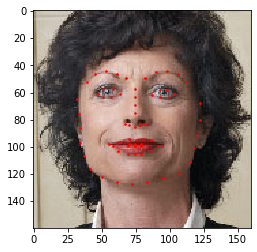

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c="r")
    plt.pause(0.001)  # pause a bit so that plots are updated
    
plt.figure
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
plt.show()

# Dataset class

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get iith sample.

Let’s create a dataset class for our face landmarks dataset. We will read the csv in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict `{'image': image, 'landmarks': landmarks}`. Our dataset will take an optional argument `transform` so that any required processing can be applied on the sample. We will see the usefulness of transform in the next section.

In [57]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset. """
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __iter__(self):
        return iter(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        print(img_name)
        print("===========")
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx,  1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
        

Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

In [60]:
face_dataset[1]

data/faces/1084239450_e76e00b7e7.jpg


{'image': array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[221, 220, 226],
         [206, 207, 211],
         [194, 197, 204],
         ...,
         [ 26,  21,  18],
         [ 20,  23,  16],
         [ 46,  42,  33]],
 
        [[223, 222, 228],
         [207, 208, 212],
         [195, 198, 205],
         ...,
         [ 41,  37,  34],
         [ 57,  43,  40],
         [ 74,  45,  41]],
 
        [[224, 223, 229],
         [208, 209, 213],
         [195, 198, 205],
         ...,
         [ 52,  45,

data/faces/0805personali01.jpg
0 (324, 215, 3) (68, 2)


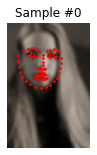

data/faces/1084239450_e76e00b7e7.jpg
1 (500, 333, 3) (68, 2)


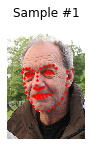

data/faces/10comm-decarlo.jpg
2 (250, 258, 3) (68, 2)


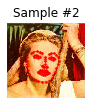

data/faces/110276240_bec305da91.jpg
3 (434, 290, 3) (68, 2)


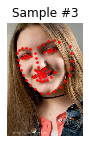

In [58]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

# Transforms

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some preprocessing code. Let’s create three transforms:

- `Rescale`: to scale the image
- `RandomCrop`: to crop from image randomly. This is data augmentation.
- `ToTensor:` to convert the numpy images to torch images (we need to swap axes).

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement `__call__` method and if required, `__init__` method. We can then use a transform like this:


```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

In [27]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        landmarks = landmarks * [new_w/w, new_h/h]
        
        return {'image': img, 'landmarks': landmarks}
    

    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top:top + new_h,
                      left:left + new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    

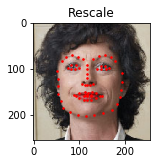

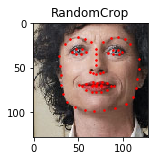

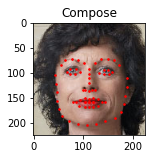

In [147]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()


# Iterating through the dataset

Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

- An image is read from the file on the fly
- Transforms are applied on the read image
- Since one of the transforms is random, data is augmented on sampling

We can iterate over the created dataset with a for i in range loop as before.

In [55]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3:
        break

data/faces/0805personali01.jpg
0 torch.Size([3, 224, 224]) torch.Size([68, 2])
data/faces/1084239450_e76e00b7e7.jpg
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
data/faces/10comm-decarlo.jpg
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
data/faces/110276240_bec305da91.jpg
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


## Another method to transform by using the pytorch library transform

```bash
transform = transforms.Compose([
    # resize
    transforms.Resize(32),
    # center-crop
    transforms.CenterCrop(32),
    # ramdonly resize and crop
    transforms.RandomSizedCrop(224),
    # ramdonly horizontal flip
    transforms.RandomHorizontalFlip(),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
```

But there is a condition that **the image has to be PIL Image type**, otherwise get such error: `TypeError: img should be PIL Image. Got <class 'dict'>`



In [179]:
from PIL import Image

class FaceKeypointsDataset(Dataset):
    """Face Landmarks dataset. """
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx,  1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        
#         ##################################################################
#         Code example of how to convert
#         PIL_image = Image.fromarray(np.uint8(numpy_image)).convert('RGB')
#         PIL_image = Image.fromarray(numpy_image.astype('uint8'), 'RGB')
#         ##################################################################
        PIL_image = Image.fromarray(image.astype('uint8'), 'RGB')
        sample = {'image': PIL_image, 'landmarks': landmarks}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample

In [180]:
transformed_data = FaceKeypointsDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               # resize
                                               transforms.Resize(256),
                                               # center-crop
                                               transforms.CenterCrop(224),
                                               # to-tensor
                                               transforms.ToTensor(),
                                               # # normalize
                                               # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])    
                                           ]))

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


for i in range(len(transformed_data)):
    sample = transformed_data[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    if i == 3:
        break

0 torch.Size([3, 224, 224]) (68, 2)
1 torch.Size([3, 224, 224]) (68, 2)
2 torch.Size([3, 224, 224]) (68, 2)
3 torch.Size([3, 224, 224]) (68, 2)


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is `collate_fn`. You can specify how exactly the samples need to be batched using `collate_fn`. However, default collate should work fine for most use cases.

### Let’s now discuss in detail the parameters that the `DataLoader` class accepts, shown below.

```bash
from torch.utils.data import DataLoader

DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )
```

1. **Dataset**: The first parameter in the `DataLoader` class is the dataset. This is where we load the data from.

2. **Batching the data**: `batch_size` refers to the number of training samples used in one iteration. Usually we split our data into training and testing sets, and we may have different batch sizes for each.

3. **Shuffling the data**: `shuffle` is another argument passed to the `DataLoader` class. The argument takes in a Boolean value (True/False). If `shuffle` is set to `True`, then all the samples are shuffled and loaded in batches. Otherwise they are sent one-by-one without any shuffling.

4. **Allowing multi-processing**: As deep learning involves training models with a lot of data, running only single processes ends up taking a lot of time. In PyTorch, you can increase the number of processes running simultaneously by allowing multiprocessing with the argument `num_workers`. This also depends on the batch size, but I wouldn’t set num_workers to the same number because each worker loads a single batch, and returns it only once it’s ready.
    - num_workers=0 means that it’s the main process that does the data loading when needed.
    - num_workers=1 means you only have a single worker, so it might be slow.


5. **Merging datasets**: The `collate_fn` argument is used if we want to merge datasets. This argument is optional, and mostly used when batches are loaded from map-styled datasets.

6. **Loading data on CUDA tensors**: You can directly load datasets as CUDA tensors using the `pin_memory` argument. It is an optional parameter that takes in a Boolean value; if set to `True`, the `DataLoader` class copies Tensors into CUDA-pinned memory before returning them.

data/faces/person.jpg
data/faces/3273658251_b95f65c244.jpg
data/faces/303808204_1f744bc407.jpg
data/faces/2210514040_6b03ff2629.jpg
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


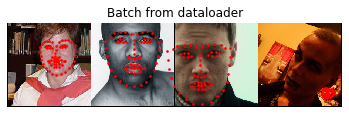

data/faces/2173711035_dbd53b4f9f.jpg
data/faces/3872768751_e60d7fdbd5.jpg
data/faces/2902760364_89c50bde40.jpg
data/faces/1878519279_f905d4f34e.jpg
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


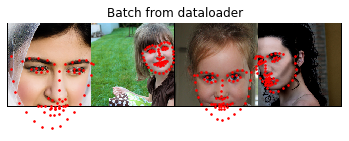

data/faces/299733036_fff5ea6f8e.jpg
data/faces/3534188114_2108895291.jpg
data/faces/2795838930_0cc5aa5f41.jpg
data/faces/2647088981_60e9fe40cd.jpg
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


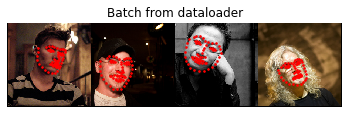

data/faces/110276240_bec305da91.jpg
data/faces/2327253037_66a61ea6fe.jpg
data/faces/3555944509_7b477069c6.jpg
data/faces/3264867945_fe18d442c1.jpg
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


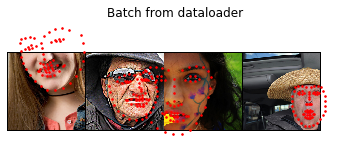

In [62]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
#     print(sample_batched)
#     print('===============')
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')
        

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 1st - 4th batches and stop.
    plt.figure()
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    if i_batch == 3:
        break


In [187]:
len(dataloader)

18

# Pytorch Text Tutorial

In [1]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [2]:
train_iter = WikiText2(split='train')
train_iter

100%|█████████████████████████████████████████████████████████████████████████████| 4.48M/4.48M [00:03<00:00, 1.25MB/s]


In [4]:
tokenizer = get_tokenizer('basic_english')

In [9]:
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [11]:
next(train_iter)

StopIteration: 

In [182]:
len(landmarks_frame)

69

In [131]:
np.array([landmarks_frame.iloc[65, 1:]]).astype('float').reshape(-1, 2, 2)

array([[[ 32.,  65.],
        [ 33.,  76.]],

       [[ 34.,  86.],
        [ 34.,  97.]],

       [[ 37., 107.],
        [ 41., 116.]],

       [[ 50., 122.],
        [ 61., 126.]],

       [[ 72., 127.],
        [ 83., 126.]],

       [[ 95., 123.],
        [107., 119.]],

       [[115., 111.],
        [118., 101.]],

       [[120.,  91.],
        [122.,  80.]],

       [[122.,  68.],
        [ 39.,  52.]],

       [[ 45.,  46.],
        [ 53.,  44.]],

       [[ 61.,  46.],
        [ 68.,  49.]],

       [[ 82.,  49.],
        [ 90.,  45.]],

       [[ 98.,  44.],
        [106.,  46.]],

       [[112.,  52.],
        [ 74.,  57.]],

       [[ 74.,  63.],
        [ 74.,  69.]],

       [[ 74.,  75.],
        [ 67.,  83.]],

       [[ 70.,  84.],
        [ 74.,  85.]],

       [[ 78.,  84.],
        [ 82.,  83.]],

       [[ 47.,  61.],
        [ 51.,  57.]],

       [[ 58.,  57.],
        [ 63.,  61.]],

       [[ 57.,  63.],
        [ 51.,  63.]],

       [[ 87.,  62.],
        [ 93

In [88]:
test = pd.read_csv('DAIC-WOZ Dataset/300_P/300_CLNF_features3D.txt')

test

,frame,timestamp,confidence,success,X0,X1,X2,X3,X4,X5,...,Z58,Z59,Z60,Z61,Z62,Z63,Z64,Z65,Z66,Z67
0,1,0.000000,0.939744,1,-7.52669,-5.39618,-1.06013,4.80662,14.68160,28.57200,...,566.219,571.111,577.231,565.848,565.408,567.131,581.638,567.067,565.300,565.966
1,2,0.033333,0.944596,1,-8.30664,-6.13205,-1.85666,3.71724,13.31800,27.37450,...,562.980,567.482,573.874,562.788,562.689,564.670,578.801,564.449,562.443,562.831
2,3,0.066667,0.947792,1,-8.41650,-6.56708,-2.72035,2.34756,11.29670,25.01500,...,560.718,564.944,571.474,560.628,560.637,562.545,576.595,562.191,560.216,560.475
3,4,0.100000,0.948344,1,-8.50655,-6.80542,-3.14729,1.65419,10.22560,23.70780,...,559.136,563.303,569.906,559.006,559.038,560.885,575.085,560.504,558.587,558.819
4,5,0.133333,0.948772,1,-8.55315,-6.90039,-3.30092,1.42815,9.90201,23.32200,...,558.478,562.587,569.183,558.283,558.325,560.162,574.375,559.814,557.912,558.129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19453,19454,648.433000,0.946191,1,-57.11970,-52.49770,-45.80310,-38.06190,-26.30600,-10.00020,...,559.427,564.972,572.296,556.532,555.336,556.635,570.950,556.691,556.001,557.525
19454,19455,648.467000,0.957569,1,-55.84150,-51.64710,-45.17150,-37.34950,-25.45310,-9.38766,...,559.040,565.451,573.601,556.153,554.783,555.810,571.787,556.006,555.476,557.134
19455,19456,648.500000,0.955773,1,-54.94990,-51.25460,-45.16240,-37.58140,-26.07670,-10.40320,...,560.017,565.023,571.586,553.355,551.964,552.965,569.808,557.232,556.842,558.295
19456,19457,648.533000,0.955048,1,-53.70620,-50.21180,-44.15650,-36.60390,-25.21100,-9.65105,...,559.162,563.145,568.278,550.226,548.957,550.117,567.023,556.527,556.133,557.356
